In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Edit here the path on drive to the data archive
!unzip drive/MyDrive/deep_perception/final_project/archive -d data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from glob import glob
from skimage.io import imread
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import KFold

PATH = "data/"

In [ ]:
# Create a DataFrame containing all data info.
def process_data(path):
    data = pd.DataFrame([{'path': filepath} for filepath in glob(PATH+path)])
    data['file'] = data['path'].map(os.path.basename)
    data['ID'] = data['file'].map(lambda x: str(x.split('_')[1]))
    data['Age'] = data['file'].map(lambda x: int(x.split('_')[3]))
    data['Contrast'] = data['file'].map(lambda x: bool(int(x.split('_')[5])))
    data['Modality'] = data['file'].map(lambda x: str(x.split('_')[6].split('.')[-2]))
    return data

In [ ]:
# print some of the datas info
tiff_data = process_data('tiff_images/*.tif')
tiff_data.head(10)

,path,file,ID,Age,Contrast,Modality
0,data/tiff_images/ID_0091_AGE_0072_CONTRAST_0_C...,ID_0091_AGE_0072_CONTRAST_0_CT.tif,0091,72,False,CT
1,data/tiff_images/ID_0005_AGE_0048_CONTRAST_1_C...,ID_0005_AGE_0048_CONTRAST_1_CT.tif,0005,48,True,CT
2,data/tiff_images/ID_0086_AGE_0073_CONTRAST_0_C...,ID_0086_AGE_0073_CONTRAST_0_CT.tif,0086,73,False,CT
3,data/tiff_images/ID_0039_AGE_0074_CONTRAST_1_C...,ID_0039_AGE_0074_CONTRAST_1_CT.tif,0039,74,True,CT
4,data/tiff_images/ID_0000_AGE_0060_CONTRAST_1_C...,ID_0000_AGE_0060_CONTRAST_1_CT.tif,0000,60,True,CT
5,data/tiff_images/ID_0047_AGE_0069_CONTRAST_1_C...,ID_0047_AGE_0069_CONTRAST_1_CT.tif,0047,69,True,CT
6,data/tiff_images/ID_0097_AGE_0060_CONTRAST_0_C...,ID_0097_AGE_0060_CONTRAST_0_CT.tif,0097,60,False,CT
7,data/tiff_images/ID_0094_AGE_0052_CONTRAST_0_C...,ID_0094_AGE_0052_CONTRAST_0_CT.tif,0094,52,False,CT
8,data/tiff_images/ID_0068_AGE_0072_CONTRAST_0_C...,ID_0068_AGE_0072_CONTRAST_0_CT.tif,0068,72,False,CT
9,data/tiff_images/ID_0087_AGE_0044_CONTRAST_0_C...,ID_0087_AGE_0044_CONTRAST_0_CT.tif,0087,44,False,CT


In [ ]:
# show some images with the info attached
def show_images(data, dim=16):
    img_data = list(data[:dim].T.to_dict().values())
    f, ax = plt.subplots(4,4, figsize=(16,20))
    for i,data_row in enumerate(img_data):
        data_row_img = imread(data_row['path'])
        ax[i//4, i%4].matshow(data_row_img,cmap='gray')
        ax[i//4, i%4].axis('off')
        ax[i//4, i%4].set_title('Modality: {Modality} Age: {Age}\nSlice: {ID} Contrast: {Contrast}'.format(**data_row))
    plt.show()

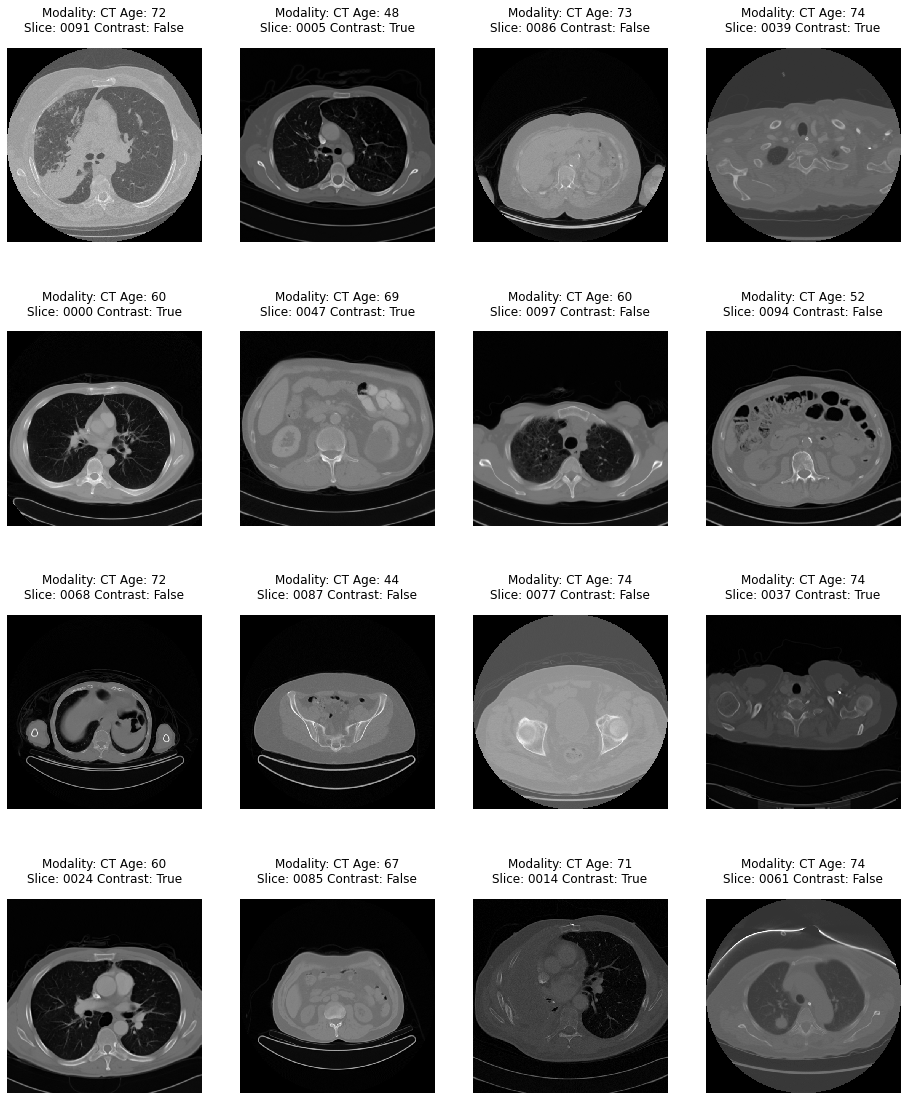

In [ ]:
show_images(tiff_data,16)

In [ ]:
# load mean and STD of all data image pixel values. Used for normalization
def load_mean_std(data):
    img_shape = imread(data[0]['path']).shape
    imgs = np.empty(shape=[len(data), img_shape[0], img_shape[1]])
    for idx, file in enumerate(data):
        path = file['path']
        img = imread(path)
        imgs[idx] = img
    MEAN = imgs.mean()
    STD = imgs.std()
    return MEAN, STD

In [ ]:
img_data = list(tiff_data.T.to_dict().values())
MEAN, STD = load_mean_std(img_data)
print(MEAN)
print(STD)

-658.2640952682495
659.1730451776253


In [ ]:
class CTScans(Dataset):
    def __init__(self, root_dir, transform, augment=True):
        self.root_dir = root_dir
        self.augment = augment
        self.transform = transform
        self.class_mappings = {'no_contrast': 0, 'contrast': 1}
        self.imgs_path = np.array(list(sorted(os.listdir(self.root_dir))))
        self.labels = np.array([int(x.split('_')[5]) for x in self.imgs_path])

    def __len__(self):
        return len(self.imgs_path)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # load image from disk
        img = imread(os.path.join(self.root_dir, self.imgs_path[idx]))
        img = img[::2,::2]
        img = Image.fromarray(img)
        # get its label
        label = self.labels[idx]

        if self.augment:
            # training mode - create two augmentations
            aug_image1 = self.transform(img)
            aug_image2 = self.transform(img)
            sample = {'image1': aug_image1, 'image2': aug_image2, 'label': label}
        else:
            # test mode - no need for augmentations
            image = self.transform(img)
            sample = {'image': image, 'label': label}

        return sample

In [ ]:
transform_train = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5), # AUGMENTATION: Random Horizontal Flip
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(), # numpy array to tensor
        transforms.Normalize(MEAN, STD) # normalize the image
     ])


transform_test = transforms.Compose(
    [
        transforms.ToTensor(),  # numpy array to tensor
        transforms.Normalize(MEAN, STD)  # normalize the image
    ])

In [ ]:
dataset = CTScans(root_dir='data/tiff_images', transform=transform_train, augment=True)

raw_dataset = CTScans(root_dir='data/tiff_images', transform=transform_test, augment=False)
size = len(dataset)

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(size*0.75), int(size*0.25)])
raw_train_dataset, raw_val_dataset, raw_test_dataset = torch.utils.data.random_split(
    raw_dataset, [int(size*0.6), int(size*0.2), int(size*0.2)])

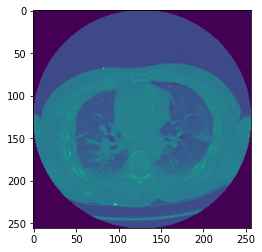

In [ ]:
# show a single sample
raw_sample = raw_train_dataset[0]
plt.imshow(raw_sample['image'].permute(1, 2, 0).squeeze())

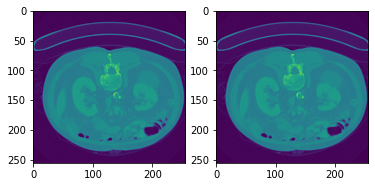

In [ ]:
# show the 2 augmented images of a single sample
first_aug_sample = train_dataset[0]
plt.subplot(1,2,1)
plt.imshow(first_aug_sample['image1'].permute(1, 2, 0).squeeze())
plt.subplot(1,2,2)
plt.imshow(first_aug_sample['image2'].permute(1, 2, 0).squeeze())

In [ ]:
def pairwise_cosine_sim(X, Y):
  '''
  The function calculates the cosine similarity between each pair in X and Y:
  X and Y are two batches of vectors and the function calculates the cosine similarity
  between each pair and return a matrix with shape [|x|,|y|] where cell [i,j] is
  the cosine similarity between X[i,:] and Y[j,:].
  '''
  x_norm = torch.norm(X, p=None, dim=1, keepdim=True)
  y_norm = torch.norm(Y, p=None, dim=1)
  norm_mult = x_norm * y_norm
  sim = torch.mm(X, Y.T) / norm_mult

  return sim


def contrastive_loss(aug1_batch, aug2_batch, temperature=0.07):
  '''
  Implementation of Eq (1).
  The function calculates the contrastive loss for the given image augmentation
  batches (aug1_batch and aug2_batch).
  '''
  batch_size = aug1_batch.shape[0]
  # concat both batches to one big batch
  full_batch = torch.cat((aug1_batch, aug2_batch))


  # compute similarity between each pair in representations matrix
  sim = pairwise_cosine_sim(full_batch, full_batch)


  # divide values by temperature
  sim /= temperature


  # calculate the denominator in the loss:
  # apply exponent on all values
  denom = torch.exp(sim)

  #    zero out similarities between samples to themselfs (remove the diagonal)
  #    and calculate the sum for each row in the matrix
  low_tril = torch.tril(denom, diagonal=-1)
  up_tril = torch.triu(denom, diagonal=1)
  new_denom = low_tril + up_tril
  sums = torch.sum(new_denom, dim=1)


  # calculate the log probabilities
  logged_sums = torch.log(sums)
  log = torch.sub(sim, logged_sums).T
  #   take only the positives: 
  #   cells where the samples should be similar we want to maximize the similarity between them
  positives = torch.cat((torch.diag(log, batch_size), torch.diag(log, -batch_size)))

  #  multiply by -1 and compute the mean (sum of log probabilities/(2*batch_size))
  loss = - (torch.sum(positives) / (2*batch_size))

  return loss

In [ ]:
def create_simclr_model():
  # create new resnet18 as the base encoder
  simclr_model = torchvision.models.resnet18(pretrained=False)
  simclr_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  # change its classifier to a projection head
  classifier = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 32)
  )
  simclr_model.fc = classifier
  return simclr_model

In [ ]:
# create an SGD optimizer
def create_optimizer(model, lr, momentum=0.9):
  return optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [ ]:
# self-supervised-train a model using contrastive loss 
# and returned the trained model and losses per epoch
def self_supervised_training(model, optimizer, train_dataloader, temperature=0.07, 
                             num_epochs=10, print_freq=30, device="cuda"):
  # move model to device
  model = model.to(device)
  losses = {}
  losses['epochs'] = []
  losses['losses'] = []
  for epoch in range(num_epochs):
    model.train()
    for (idx, aug_batch) in enumerate(train_dataloader):
      optimizer.zero_grad()
      aug_batch1 = aug_batch['image1'].to(device)
      aug1_output = model(aug_batch1)
      aug_batch2 = aug_batch['image2'].to(device)
      aug2_output = model(aug_batch2)
      loss = contrastive_loss(aug1_output, aug2_output, temperature)
      loss.backward()
      optimizer.step()

      loss_value = loss.cpu().data.item()
    if epoch % print_freq == 0:
      print(f"Epoch {epoch}, Contrastive loss={loss_value}")
      losses['epochs'].append(epoch)
      losses['losses'].append(loss_value)

  return model, losses

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)

test_loader = DataLoader(test_dataset, len(test_dataset), shuffle=True)

raw_loader = DataLoader(raw_dataset, batch_size=50, shuffle=True)


In [ ]:
feat_dim = 32

# extract features and labels from dataloader using a trained model
def extract_features_and_labels(model, dataloader, is_augmented):
  _ = model.eval()
  # create empty placeholders
  features = torch.empty((0, feat_dim))
  labels = torch.empty(0, dtype=torch.long)
  for (_, batch) in enumerate(dataloader):
    if is_augmented:
      image = batch['image1']
      curr_feats = model(image.to("cuda"))
      features = torch.cat((features, curr_feats.cpu().detach()))
      curr_labels = batch['label']
      labels = torch.cat((labels, curr_labels))
      image = batch['image2']
      curr_feats = model(image.to("cuda"))
      features = torch.cat((features, curr_feats.cpu().detach()))
      curr_labels = batch['label']
      labels = torch.cat((labels, curr_labels))
    else:
      image = batch['image']
      curr_labels = batch['label']
      curr_feats = model(image.to("cuda"))
      features = torch.cat((features, curr_feats.cpu().detach()))
      labels = torch.cat((labels, curr_labels))
  return features.numpy(), labels.numpy()

In [ ]:
# Used for data visualization of features extracted from the SimCLR model

# train_features, train_labels = extract_features_and_labels(simclr_model, raw_loader, is_augmented=False)
# from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2)
# train_features_emb = tsne.fit_transform(train_features)
# classes = np.unique(train_labels)
# plt.rcParams["figure.figsize"] = (13,5)
# class_dict =  {0: 'no_contrast', 1: 'contrast'}
# scatter_x = train_features_emb[:,0]
# scatter_y = train_features_emb[:,1]
# group = train_labels
# cdict = {0: 'red', 1: 'blue'}
# # 'car': 0, 'dog': 1, 'elephant': 2, 'cat': 3, 'airplane': 4
# fig, ax = plt.subplots()
# for g in np.unique(group):
#     ix = np.where(group == g)
#     ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = class_dict[g], s = 100)
# ax.legend()
# plt.title('SimCLR extracted features visualiztion')
# plt.show()

In [ ]:
class Classifier(nn.Module):
    def __init__(self, feature_size):
        '''
        Declare layers for the model
        '''
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(feature_size, 256)
        self.fc2 = nn.Linear(256, 1024)
        self.fc3 = nn.Linear(1024, 128)
        self.fc4 = nn.Linear(128, 2)
        
    def forward(self, x):
        ''' Forward pass through the network, returns log_softmax values '''
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)

In [ ]:
# Train the classifier
def train_model(model, optimizer, criterion,
                nepochs, train_loader):
  '''
  Train a pytorch model and evaluate it every epoch.
  Params:
  model - a pytorch model to train
  optimizer - an optimizer 
  criterion - the criterion (loss function)
  nepochs - number of training epochs
  train_loader - dataloader for the trainset
  val_loader - dataloader for the valset
  '''
  train_losses, val_losses = [], []
  for e in range(nepochs):
      running_loss = 0
      running_val_loss = 0
      correct, total = 0, 0
      for images, labels in train_loader:
          # Training pass
          model.train() # set model in train mode
          optimizer.zero_grad()
          output = model.forward(images)
          loss = criterion(output, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
          
      train_losses.append(running_loss)
      print("Epoch: {}/{}.. ".format(e+1, nepochs),
            "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)))
  return train_losses

In [ ]:
# evaluate the accuracy of a trained model
def evaluate_model(model, val_loader):
  '''
  Evaluate a model on the given dataloader.
  Params:
  model - a pytorch model to train
  val_loader - dataloader for the valset
  '''
  validation_accuracy = 0
  with torch.no_grad():
      for images, labels in val_loader:
          # forward pass
          log_ps = model(images)
          ps = torch.exp(log_ps)
          top_p, top_class = ps.topk(1, dim=1)
          # count correct predictions
          equals = top_class == labels.view(*top_class.shape)
          
          validation_accuracy += torch.sum(equals.type(torch.FloatTensor))
  res = validation_accuracy/len(val_loader.dataset)
  return res

In [ ]:
# evaluate the model using k-folds cross-validation
learning_rate = 0.0001
nepochs = 50
criterion = nn.NLLLoss()

k_folds = 5
results = {}

kfold = KFold(n_splits=k_folds, shuffle=True)

for fold, (train_ids, test_ids) in enumerate(kfold.split(train_dataset)):
  print(f'FOLD {fold}')
  print('--------------------------------')
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
  trainloader = torch.utils.data.DataLoader(
                      train_dataset, 
                      batch_size=len(train_dataset), sampler=train_subsampler)
  testloader = torch.utils.data.DataLoader(
                      train_dataset,
                      batch_size=1, sampler=test_subsampler)
  


  # hyper params
  num_epochs = 30
  lr=0.01

  # Create new instance of the model
  simclr_model = create_simclr_model()
  # Create optimizer
  simclr_opt = create_optimizer(simclr_model, lr=lr, momentum=0.9)
  # Train the model
  simclr_model, _ = self_supervised_training(simclr_model, simclr_opt, trainloader,
                                          num_epochs=num_epochs, print_freq=5, device="cuda")
  
  fold_train_features, fold_train_labels = extract_features_and_labels(simclr_model, trainloader, is_augmented=True)
  fold_train_features_dataset = TensorDataset(torch.Tensor(fold_train_features), torch.Tensor(fold_train_labels).long())

  fold_train_features_loader = DataLoader(fold_train_features_dataset, batch_size=1)

  classifier = Classifier(fold_train_features.shape[1])
  optimizer = optim.Adam(classifier.parameters(), lr=learning_rate)

  for epoch in range(0, nepochs):
    # Print epoch
    print(f'Starting epoch {epoch+1}')

    # Set current loss value
    current_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(fold_train_features_loader, 0):
      
      # Get inputs
      inputs, targets = data
      
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      outputs = classifier(inputs)
      
      # Compute loss
      loss = criterion(outputs, targets)
      
      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      current_loss += loss.item()
      # if i % 500 == 499:
      #   print('Loss after mini-batch %5d: %.3f' %
      #         (i + 1, current_loss / 500))
    # Process is complete.
    print('Training process has finished.')

    # Print about testing
    print('Starting testing')

    # Evaluation for this fold
    correct, total = 0, 0
    with torch.no_grad():

      fold_test_features, fold_test_labels = extract_features_and_labels(simclr_model, testloader, is_augmented=True)
      fold_test_features_dataset = TensorDataset(torch.Tensor(fold_test_features), torch.Tensor(fold_test_labels).long())
      fold_test_features_loader = DataLoader(fold_test_features_dataset, batch_size=1)
  
      # Iterate over the test data and generate predictions
      for i, data in enumerate(fold_test_features_loader, 0):

        # Get inputs
        inputs, targets = data

        # Generate outputs
        outputs = classifier(inputs)

        # Set total and correct
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

      # Print accuracy
      print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
      print('--------------------------------')
      results[fold] = 100.0 * (correct / total)

# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
sum = 0.0
for key, value in results.items():
  print(f'Fold {key}: {value} %')
  sum += value
print(f'Average: {sum/len(results.items())} %')
            

FOLD 0
--------------------------------
Epoch 0, Contrastive loss=4.515665054321289
Epoch 5, Contrastive loss=2.4659228324890137
Epoch 10, Contrastive loss=1.8050763607025146
Epoch 15, Contrastive loss=1.418150544166565
Epoch 20, Contrastive loss=0.9374755024909973
Epoch 25, Contrastive loss=0.6346215605735779
Starting epoch 1
Training process has finished.
Starting testing
Accuracy for fold 0: 53 %
--------------------------------
Starting epoch 2
Training process has finished.
Starting testing
Accuracy for fold 0: 66 %
--------------------------------
Starting epoch 3
Training process has finished.
Starting testing
Accuracy for fold 0: 63 %
--------------------------------
Starting epoch 4
Training process has finished.
Starting testing
Accuracy for fold 0: 53 %
--------------------------------
Starting epoch 5
Training process has finished.
Starting testing
Accuracy for fold 0: 53 %
--------------------------------
Starting epoch 6
Training process has finished.
Starting testing
Acc

In [ ]:
# hyper params
num_epochs = 30
lr=0.01

# Create new instance of the model
simclr_model = create_simclr_model()
# Create optimizer
simclr_opt = create_optimizer(simclr_model, lr=lr, momentum=0.9)

# Train the SimCLR model
simclr_model, losses = self_supervised_training(simclr_model, simclr_opt, train_loader,
                                        num_epochs=num_epochs, print_freq=1, device="cuda")

train_features, train_labels = extract_features_and_labels(simclr_model, train_loader, is_augmented=True)
train_features_dataset = TensorDataset(torch.Tensor(train_features), torch.Tensor(train_labels).long())

train_features_loader = DataLoader(train_features_dataset, batch_size=1)

classifier = Classifier(train_features.shape[1])

optimizer = optim.Adam(classifier.parameters(), lr=learning_rate)

# Train classifier
train_losses = train_model(classifier, optimizer, criterion, nepochs,
                                       train_features_loader)

Epoch 0, Contrastive loss=4.502135276794434
Epoch 1, Contrastive loss=3.851311206817627
Epoch 2, Contrastive loss=3.479573965072632
Epoch 3, Contrastive loss=3.2791244983673096
Epoch 4, Contrastive loss=3.1078085899353027
Epoch 5, Contrastive loss=2.7321324348449707
Epoch 6, Contrastive loss=2.987802505493164
Epoch 7, Contrastive loss=3.2041573524475098
Epoch 8, Contrastive loss=2.427156925201416
Epoch 9, Contrastive loss=2.2501001358032227
Epoch 10, Contrastive loss=2.120588541030884
Epoch 11, Contrastive loss=1.9935048818588257
Epoch 12, Contrastive loss=1.9418119192123413
Epoch 13, Contrastive loss=1.8564722537994385
Epoch 14, Contrastive loss=1.7586190700531006
Epoch 15, Contrastive loss=1.6942769289016724
Epoch 16, Contrastive loss=1.6500853300094604
Epoch 17, Contrastive loss=1.5886272192001343
Epoch 18, Contrastive loss=1.4832763671875
Epoch 19, Contrastive loss=1.420638084411621
Epoch 20, Contrastive loss=1.334112524986267
Epoch 21, Contrastive loss=1.212643027305603
Epoch 22, 

In [ ]:
aug_test_features, aug_test_labels = extract_features_and_labels(simclr_model, test_loader, is_augmented=True)
aug_test_dataset = TensorDataset(torch.Tensor(aug_test_features), torch.Tensor(aug_test_labels).long())
aug_test_loader = DataLoader(aug_test_dataset, batch_size=1, shuffle=True)

print(aug_test_features.shape)
print(f"Test accuracy: {evaluate_model(classifier, aug_test_loader)}")

(50, 32)
Test accuracy: 0.7599999904632568


Text(0.5, 1.0, 'SimCLR loss plot')

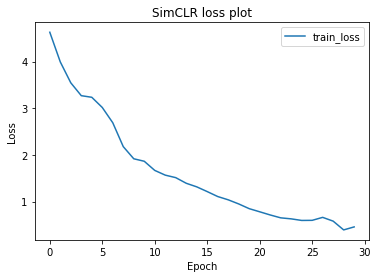

In [ ]:
plt.plot(losses['epochs'], losses['losses'])
plt.legend(["train_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SimCLR loss plot")

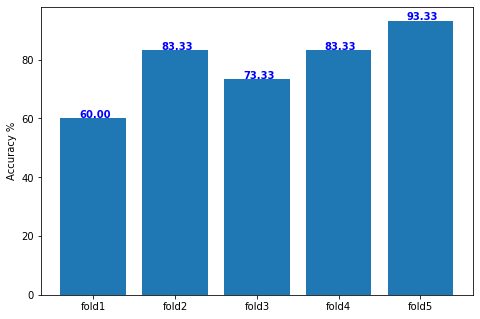

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
folds = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5']
plt.ylabel("Accuracy %")
ax.bar(folds,results.values())
for index, acc in enumerate(results.values()):
    ax.text(index-0.17, acc + .25, "{:.2f}".format(acc), color='blue', fontweight='bold')

Text(0.5, 1.0, 'classifier loss plot')

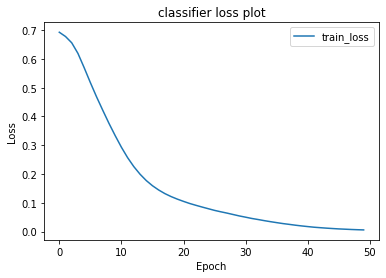

In [ ]:
plt.plot(range(0,nepochs), np.array(train_losses)/len(train_features_loader))
plt.legend(["train_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("classifier loss plot")